### 1. Import libraries and datasets

In [129]:
# Basic libraries
import numpy as np
import pandas as pd

# Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                             GradientBoostingClassifier, AdaBoostClassifier, \
                             VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [130]:
# Read the datasets

clean_onion = pd.read_csv('./processed_onion.csv')
clean_notonion = pd.read_csv('./processed_notonion.csv')

In [131]:
# combine the datasets

combined_df = pd.concat([clean_onion,clean_notonion])

In [132]:
combined_df.shape

(8886, 11)

In [133]:
combined_df.to_csv('combined_df.csv', index=False)

In the previous section, we have performed the text processing and cleaning from the dataset we scrapped from subreddits `r/theonion` and `r/nottheonion`. The next step we will proceed to the following steps:

1. Create a baseline model
2. To transform the data using vectorizers, Countvectorizer and TfidfVectorizer
3. Fit the model to train the datasets
4. Evaluate the models base on some evaliation matrics (Precision, ROC-AUC)
5. Select the best models and tune hyper-parameters

Countvectorizer and TfidfVectorizer are used to convert the text to a numeric form. Term Frequency Inverse Document Frequency (TFIDF) works by roportionally increasing the number of times a word appears in the document but is counterbalanced by the number of documents in which it is present. While Countvectorizeralso called Bag-of-Words which converts text into fixed-length vectors by counting how many times each word appears.

We will select a range of classification techniques to test including Logistic Regression,Random Forest and Support Vector Machine (SVM) classification.

### 2. Baseline Model

#### 2a. Binarize Target subreddit

In [134]:
# Replace `TheOnion` with 1, `nottheonion` with 0
combined_df["type"] = combined_df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})


# Preview head of df to show 1s
combined_df.head(2)

,subreddit,author,domain,title,num_comments,score,timestamp,tokens,tokens_1,lemma_words,clean_text,type
0,TheOnion,mothershipq,theonion.com,surgeon kind pissed patient seeing deformed fa...,0,1,2021-12-31,"['surgeon', 'kind', 'pissed', 'patient', 'seei...","['surgeon', 'kind', 'pissed', 'patient', 'seei...","['surgeon', 'kind', 'pissed', 'patient', 'seei...",surgeon kind pissed patient seeing deformed fa...,1
1,TheOnion,-ImYourHuckleberry-,theartnewspaper.com,mcdonald’s blocked building drivethrough romes...,1,1,2021-12-31,"['mcdonald’s', 'blocked', 'building', 'driveth...","['mcdonald', 'blocked', 'building', 'drivethro...","['mcdonald', 'blocked', 'building', 'drivethro...",mcdonald blocked building drivethrough rome an...,1


#### 2b. Baseline Model

In [135]:
# Baseline
y = combined_df['type']
y.value_counts(normalize=True)

0    0.857529
1    0.142471
Name: type, dtype: float64

The baseline model normalised the value of y which is the simplest model that we can expect the model to be better than 85.7%. The majority class is from true news - `r/nottheonion`.

### 3. Model preparation

In [136]:
# To set the y (target) and x (preditor) variables

X = combined_df['clean_text']
y = combined_df['type']

In [137]:
# Split our data into train and test data. We're stratifying here to ensure that the train and test sets 
# have approximately the same percentage of samples in order to avoid imbalanced classes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [138]:
# Create list to store model testing results
eval_list = []

In [139]:
# Instantiate vectorizers
vectorizers = {'cvec': CountVectorizer(),
               'tvec': TfidfVectorizer()}

In [140]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=100, random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'svc': SVC(random_state=42)}

In [141]:
# Function to run model -- input vectorizer and model
def run_model(vec, mod, vec_params={}, mod_params={}, grid_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    if grid_search:
        gs = GridSearchCV(pipe, param_grid = {**vec_params, **mod_params}, cv=5, verbose=1, n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
        
      # Retrieve metrics
    results['model'] = mod
    results['vectorizer'] = vec
    results['train'] = pipe.score(X_train, y_train)
    results['test'] = pipe.score(X_test, y_test)
    results['roc'] = roc_auc_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
   
    
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        eval_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

### 4. Models Testing

#### 4a. Logistic Regression

Logistic Regression is very easy to understand and requires less training. It performs well for simple datasets and they are easier to implement, interpret, and very efficient to train.

In [142]:
# Logistic Regression with CountVectorizer
cvec_lr = run_model('cvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.9721864951768489,
 'test': 0.8747186796699175,
 'roc': 0.5901471197679238,
 'precision': 0.73}

True Negatives: 2259
False Positives: 27
False Negatives: 307
True Positives: 73


In [143]:
# Logistic Regression with TfdifVectorizer
tvec_lr = run_model('tvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.8667202572347267,
 'test': 0.8623405851462865,
 'roc': 0.5182023299719113,
 'precision': 0.9333333333333333}

True Negatives: 2285
False Positives: 1
False Negatives: 366
True Positives: 14


#### 4b. Random Forest

Random forests are a supervised Machine learning algorithm that is widely used in regression and classification problems and produces, even without hyperparameter tuning a great result most of the time. It is perhaps the most used algorithm because of its simplicity. It builds a number of decision trees on different samples and then takes the majority vote if it’s a classification problem.

In [144]:
# Random Forest with CountVectorizer

cvec_rf = run_model('cvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'cvec',
 'train': 0.9995176848874598,
 'test': 0.8619654913728432,
 'roc': 0.5618662798729106,
 'precision': 0.5625}

True Negatives: 2244
False Positives: 42
False Negatives: 326
True Positives: 54


In [145]:
# Random Forest with TfdifVectorizer

tvec_rf = run_model('tvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'train': 0.9990353697749196,
 'test': 0.8642160540135033,
 'roc': 0.5587903485748491,
 'precision': 0.6097560975609756}

True Negatives: 2254
False Positives: 32
False Negatives: 330
True Positives: 50


#### 4c. Support Vector Machine Classifier

Support Vector Machine is under  “supervised machine learning algorithms” category. It can be used for classification, as well as for regression. In this model,we perform the process of classification by finding differentiates the two classes.

In [146]:
# Support Vector Machine with CountVectorizer

cvec_svc = run_model('cvec', 'svc')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'cvec',
 'train': 0.9461414790996785,
 'test': 0.8649662415603901,
 'roc': 0.5285099231017175,
 'precision': 0.9166666666666666}

True Negatives: 2284
False Positives: 2
False Negatives: 358
True Positives: 22


In [147]:
# Support Vector Machine with TfdifVectorizer

tvec_svc = run_model('tvec', 'svc')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'train': 0.9678456591639871,
 'test': 0.8627156789197299,
 'roc': 0.5195181194455956,
 'precision': 0.9375}

True Negatives: 2285
False Positives: 1
False Negatives: 365
True Positives: 15


In [148]:
eval_df = pd.DataFrame(eval_list)

In [149]:
# Top results 

eval_df.sort_values(by='test', ascending=False).reset_index(drop=True)

,model,vectorizer,train,test,roc,precision
0,lr,cvec,0.972186,0.874719,0.590147,0.730000
1,svc,cvec,0.946141,0.864966,0.528510,0.916667
2,rf,tvec,0.999035,0.864216,0.558790,0.609756
3,svc,tvec,0.967846,0.862716,0.519518,0.937500
4,lr,tvec,0.866720,0.862341,0.518202,0.933333
5,rf,cvec,0.999518,0.861965,0.561866,0.562500


As our Random Forest models don't have coefficients, we'll go with the models that returned the best results across the board -- we can see that both our logistic regression and support vector machine did quite well. We will to section Model tunning below.

### 5. Model Tunnning

In [150]:
# Instantiate list to store tuning results
tuning_list = []

#### 5a. Vectorizer Parameter

In [175]:
cvec_params = {
    # Setting a limit of n-number of features included/vocab size
    'cvec__max_features': [None,9000],

    # Setting a minimum number of times the word/token has to appear in n-documents
    'cvec__min_df':[3, 4, 5],
    
    # Setting an upper threshold/max percentage of n% of documents from corpus 
    'cvec__max_df': [0.2, 0.3, 0.4],
    
    # With stopwords
    'cvec__stop_words': ['english'],
    
    # Testing with bigrams and trigrams
    'cvec__ngram_range':[(1,1), (1,2)],
}

In [168]:
tvec_params = {
    'tvec__max_features': [None],
    'tvec__min_df':[3, 4, 5],
    'tvec__max_df': [0.2, 0.3, 0.4],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range':[(1,1), (1,2)]
}

#### 5b. Model Parameters

In [169]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1'],

     # Trying different alphas of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[0.1, 1, 10],
}

In [203]:
svc_params = {
    'svc__C':[0.1, 1, 30],
    'svc__gamma':[0.01, 0.1, 0.8], 
    'svc__kernel':['linear'],
}

There are some explanation of the parameters:

* Alpha is the level of regularization which we intended to  generalize better on unseen data, by preventing the algorithm from overfitting the training dataset.

* C is a penalty parameter, which imposes a penalty to the logistic model for having too many variables. This results in shrinking the coefficients of the less contributive variables toward zero.

* Gamma defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'. 

### 6. Hyperparameter Tuning

#### 6a. Logistic Regression with CVEC

In [171]:
# Always stop_words & never trigrams (best_results without model tuning)

cvec_lr_gs = run_model('cvec', 'lr', vec_params=cvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
### BEST PARAMS ###


{'cvec__max_df': 0.2,
 'cvec__max_features': None,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'lr__C': 1,
 'lr__penalty': 'l2'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.9372990353697749,
 'test': 0.8728432108027007,
 'roc': 0.5912476400976194,
 'precision': 0.6880733944954128}

True Negatives: 2252
False Positives: 34
False Negatives: 305
True Positives: 75


#### 6b. Logistic Regression with TVEC

In [172]:
tvec_lr_gs = run_model('tvec', 'lr', vec_params=tvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
### BEST PARAMS ###


{'lr__C': 10,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.9733118971061093,
 'test': 0.8724681170292573,
 'roc': 0.6250379886724685,
 'precision': 0.6162790697674418}

True Negatives: 2220
False Positives: 66
False Negatives: 274
True Positives: 106


#### 6c.Support Machine Classifier with TVEC

In [204]:
tvec_svc_gs = run_model('tvec', 'svc', vec_params=tvec_params, mod_params=svc_params, grid_search=True)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
### BEST PARAMS ###


{'svc__C': 1,
 'svc__gamma': 0.01,
 'svc__kernel': 'linear',
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'train': 0.9110932475884245,
 'test': 0.8728432108027007,
 'roc': 0.575888704701386,
 'precision': 0.7530864197530864}

True Negatives: 2266
False Positives: 20
False Negatives: 319
True Positives: 61


#### 6d. Support Machine Classifier with CVEC

In [205]:
cvec_svc_gs = run_model('cvec', 'svc', vec_params=cvec_params, mod_params=svc_params, grid_search=True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
### BEST PARAMS ###


{'cvec__max_df': 0.2,
 'cvec__max_features': None,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'svc__C': 0.1,
 'svc__gamma': 0.01,
 'svc__kernel': 'linear'}

### METRICS ###


{'model': 'svc',
 'vectorizer': 'cvec',
 'train': 0.8815112540192926,
 'test': 0.8623405851462865,
 'roc': 0.5258817976700282,
 'precision': 0.7241379310344828}

True Negatives: 2278
False Positives: 8
False Negatives: 359
True Positives: 21


### 8. Final Model Selection

In [206]:
tuning_df = pd.DataFrame(tuning_list)

In [214]:
tuning_df.sort_values(by=['test', 'roc'], ascending=False).reset_index(drop=True)

,model,vectorizer,train,test,roc,precision
0,lr,cvec,0.937299,0.872843,0.591248,0.688073
1,lr,cvec,0.937299,0.872843,0.591248,0.688073
2,svc,tvec,0.911093,0.872843,0.575889,0.753086
3,svc,tvec,0.911093,0.872843,0.575889,0.753086
4,lr,tvec,0.973312,0.872468,0.625038,0.616279
5,lr,tvec,0.973312,0.872468,0.625038,0.616279
6,svc,cvec,0.893730,0.865341,0.534214,0.818182
7,svc,cvec,0.881511,0.862341,0.525882,0.724138


From the finding above, logistic regression with CountVectorizer give the highest train result with 68.8% of R2 accuracy of the test data based on our text features. 


While the Support Machine Vector model with TfidfVectorizer is better at R2 accuracy which give 75.3% and logistic regression with  TfidfVectorizer give the best AUC-ROC score 62.5%.

To summarize, our final model:

* uses Tfidf Vectorization with no max feature limit
* includes only words or n-grams that appear in at least 4 posts
* uses Logistic Regression with Ridge regularization( = 0.1 | C = 10) </i>

Our model is still overfitting quite a bit as indicated by the large gap between training and test scores, but this seems to be the limit to which we can push our model.

### 9. AUC-ROC Curve

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

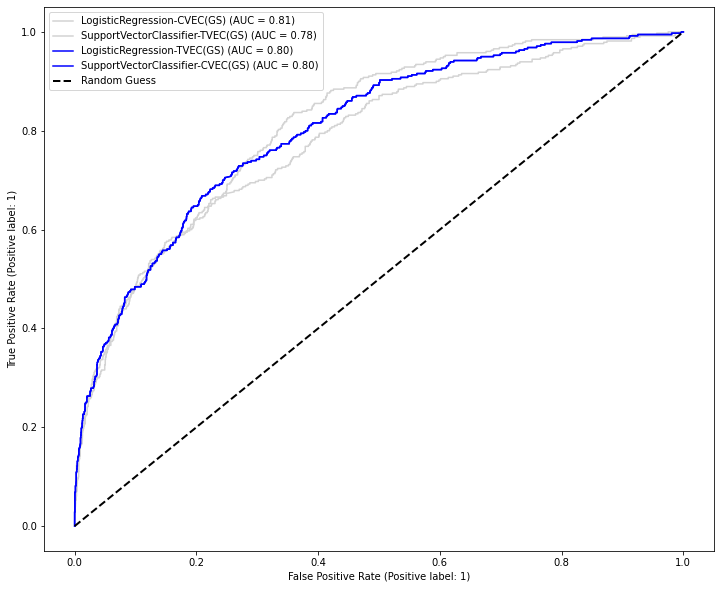

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(cvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-CVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_svc_gs, X_test, y_test, ax=ax, name='SupportVectorClassifier-TVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-TVEC(GS)', color='blue')
plot_roc_curve(tvec_lr_gs, X_test, y_test, ax=ax, name='SupportVectorClassifier-CVEC(GS)', color='blue')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend()

From the above, Logistic Regression with CountVectorizer give the highest 0.81  as indicated by the AUC-ROC curve. The other classifiers also perform quite close to the model, but it's clear that our chosen model is generally outperforming the other models at most decision thresholds, apart from the start of the curve.

### 10. Model Insights

In [215]:
cvec_lr_gs.best_estimator_


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, min_df=3, stop_words='english')),
                ('lr', LogisticRegression(C=1, random_state=42))])

In [216]:
coefs = pd.DataFrame(cvec_lr_gs.best_estimator_.steps[1][1].coef_).T
coefs.columns = ['coef']
coefs['ngram'] = cvec_lr_gs.best_estimator_.steps[0][1].get_feature_names()
coefs = coefs[['ngram','coef']]
coefs = coefs.sort_values('coef', ascending=True)

In [217]:
top_truenews_coefs = coefs.head(15).reset_index(drop=True)
top_fakenews_coefs = coefs.tail(15).sort_values(by='coef', ascending=False).reset_index(drop=True)

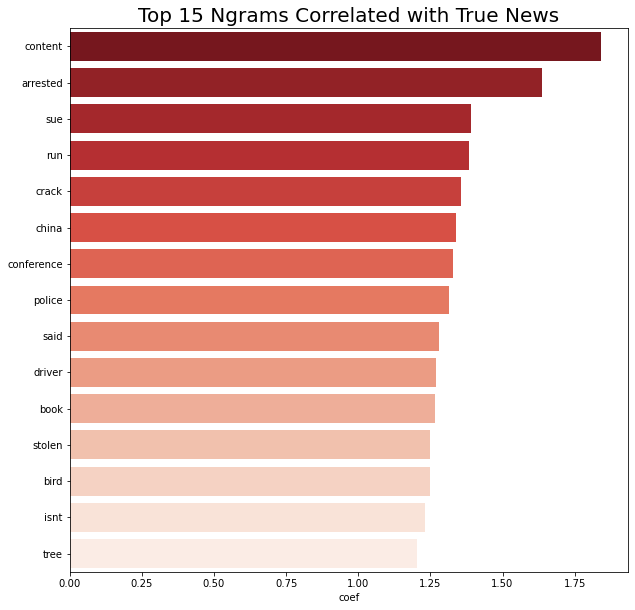

In [218]:
plt.figure(figsize=(10,10))
sns.barplot(data=top_truenews_coefs, x=-top_truenews_coefs['coef'], y='ngram', palette='Reds_r')
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with True News', fontsize=20);

From the above, we can see that the word `content` and `arrested` top the correlations in the True News in the r/nottheonion. The word `content` mostly used by the author `Starlight-786` in `r/nottheonion` when he made the post the news. We can see that the authors in this subreddit have a habbit to include this word in the post's title.

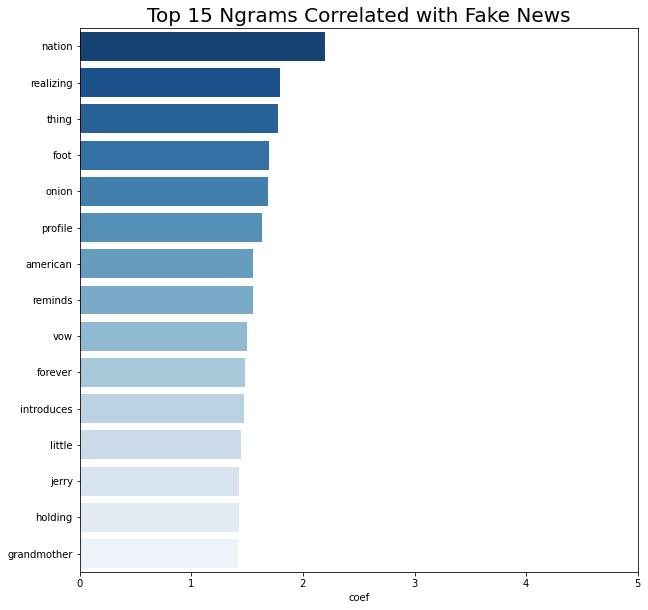

In [219]:
plt.figure(figsize=(10,10))
sns.barplot(data=top_fakenews_coefs, x=top_fakenews_coefs['coef'], y='ngram', palette='Blues_r')
plt.xticks(np.arange(0, 6, step=1))
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with Fake News', fontsize=20);

`r/theonion` is much more focus on `nation` and `realizing` which mostly posted by the author `dwaxe`.

### 11. Conclusion

The most optimal model for detecting the fake news is using the logistic regression with CountVectorizer. The optimal parameters for this model are with ngram_range = (1,1) and alpha = 10.

* Accuracy: 68.8%
* ROC: 59.1%
* Train: 93.7%
* Test: 87.3%

Model sufficiently good to classify posts - 68.8% accuracy with almost 70% of lost data will be recovered correctly.

Limitation:
    
The major limitation of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables. By using Logistic Regression, non-linear problems can’t be solved because it has a linear decision surface. Logistic Regression should not be used if the number of observations is lesser than the number of features, otherwise, it may lead to overfitting.

Recommendations:
    
● More data to train model

● Examine text more closely

    * Remove words that do not provide additional information
    
● Engineer metadata as additional features

    * Character count, word count, sentiment analysis etc